In [63]:
# import headers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from numpy.linalg import inv
from numpy.linalg import norm
import random
import time

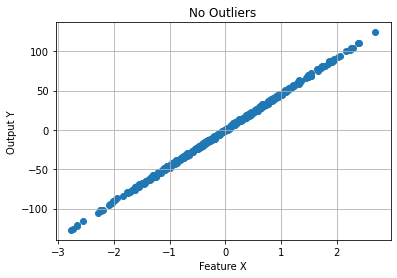

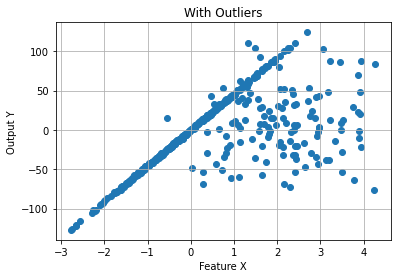

In [152]:
# generate data points (with and without outliers)

n_samples = 500
fr = 0.25
n_outliers = int(fr * n_samples)

X,Y = make_regression(n_samples = n_samples, n_features = 1, noise = 1,random_state=0)

# add outlier points
np.random.seed(0)
X_out = X.copy()
Y_out = Y.copy()
X_out[:n_outliers] = 2 + np.random.normal(size=(n_outliers,1))
#Y_out[:n_outliers] = -3 + 10 * np.random.normal(size=n_outliers)

plt.scatter(X, Y)
plt.title("No Outliers")
plt.xlabel("Feature X")
plt.ylabel("Output Y")
plt.grid()
plt.show()
plt.scatter(X_out,Y_out)
plt.title("With Outliers")
plt.xlabel("Feature X")
plt.ylabel("Output Y")
plt.grid()
plt.show()

In [3]:
# implement some functions for basic matrix operations
def t(A):
    return A.transpose()

def MM(A, B):
    return np.matmul(A, B)

In [99]:
# function to plot the best-fit line on top of the data points
def Plot(X,Y,line,title):
    plt.scatter(X, Y)
    temp_x = np.linspace(-3,3,100)
    m = line[0]
    c = line[1]
    temp_y = m * temp_x + c
    plt.plot(temp_x,temp_y,label=title,color='red')
    plt.legend(loc='lower right')
    plt.xlabel('Feature X')
    plt.ylabel('Output Y')
    plt.grid()
    plt.show()

(500, 1)
Time:  0.0005080699920654297
error:  21.57497870418033
(500, 1)
Time:  0.00014901161193847656
error:  782.6431423665975


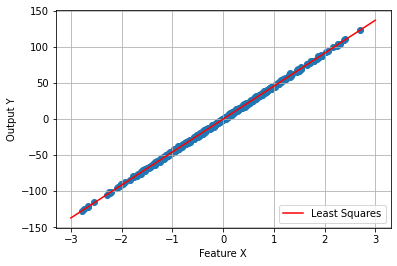

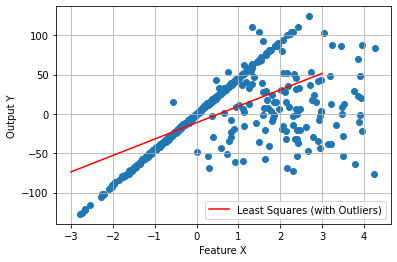

In [153]:
# implement Least Squares

def LeastSquares(X,Y,n_samples):
    t1 = time.time()
    Y = Y.reshape((n_samples, 1))
    ones = np.full((n_samples, 1), 1)
    A = np.append(X,ones,axis=1)

    # Now need to find least squares solution for Ax = Y
    sol = MM(inv(MM(t(A),A)),MM(t(A),Y))
    t2 = time.time()
    error = MM(A, sol) - Y
    print(error.shape)
    error = np.linalg.norm(error)
    print("Time: ", t2 - t1)
    print('error: ', error)
    return sol

sol = LeastSquares(X,Y,n_samples)
sol_out = LeastSquares(X_out, Y_out, n_samples)
Plot(X,Y,sol,'Least Squares')
Plot(X_out,Y_out,sol_out, 'Least Squares (with Outliers)')


(500, 1)
#iterations: 2  execution time: 0.011020898818969727  error: 104.70419335636734
(500, 1)
#iterations: 16  execution time: 0.04840493202209473  error: 1245.1430478486159


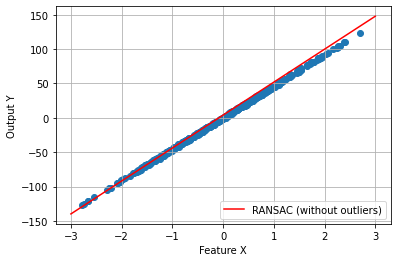

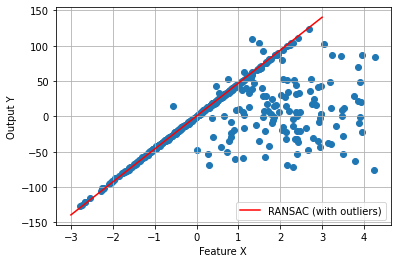

In [133]:
# implement RANSAC

from math import log

def RANSAC(X, Y, w, p, n_samples):
    t1 = time.time()
    indices = list(range(n_samples))
    threshold = np.std(Y)/5
    Y = Y.reshape((n_samples, 1))

    #iterations = 200
    N = int(log(1 - p)/log(1 - (w * w))) # no. of iterations
    max_count = 0 # max number of accurately predicted points (which lie within threshold)
    line = [-1, -1] # parameters of the best fit line

    for _ in range(N):
        point1, point2 = random.sample(indices, 2)
        x1,x2,y1,y2 = X[point1][0],X[point2][0],Y[point1][0],Y[point2][0] # two random points
        m = (y1 - y2)/(x1 - x2) # slope of the line 
        c = m * (-x1) + y1 # offset
        # then eqn of line: y = mx + c

        # now find out how many points lie within threshold of this line
        count = 0 # no. of correctly predicted points by this line
        for i in range(n_samples):
            y = Y[i]
            y_ = m * X[i] + c
            if abs(y-y_) <= threshold:
                count += 1
        if count > max_count:
            line[0], line[1] = m, c
            max_count = count
            
    ones = np.full((n_samples, 1), 1)
    A = np.append(X,ones,axis=1)
    
    ans = np.array([[line[0]],[line[1]]])
    error = MM(A,ans) - Y
    print(error.shape)
    error = np.linalg.norm(error)
    
    t2 = time.time()
    print('#iterations:', N, ' execution time:', t2 - t1, ' error:',error)
    return line
        
line_1 = RANSAC(X, Y, 0.999, 0.999999, n_samples)
line_2 = RANSAC(X_out, Y_out, 1-fr, 0.999999, n_samples)
Plot(X, Y, line_1, 'RANSAC (without outliers)')
Plot(X_out, Y_out, line_2, 'RANSAC (with outliers)')

exec time:  0.008730173110961914
error:  12.945012531624476
exec time:  0.029024124145507812
error:  1041.7324993418129


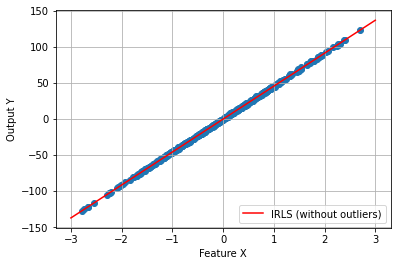

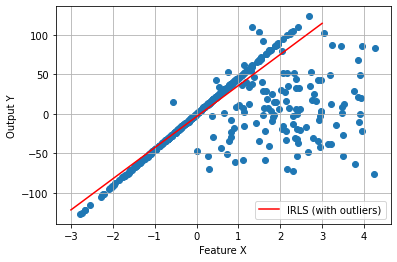

In [141]:
# implement IRLS

def IRLS(X, Y, n_samples, sigma, eps):
    t1 = time.time()
    # reshape Y and create A similar to Least Squares
    Y = Y.reshape((n_samples, 1))
    ones = np.full((n_samples, 1), 1)
    A = np.append(X,ones,axis=1)

    x = np.array([[1], [1]]) # initial guesses
    #x_prev = np.array([[10], [0]])
    #x.reshape((2, 1))
    #x_prev.reshape((2, 1))
    phi = np.identity(n_samples)
    
    do = True
    while do:
        x_prev = x
        e = MM(A,x) - Y
        #print(e.shape)
        phi = np.identity(n_samples)
        for i in range(n_samples):
            temp = (sigma**2)/((e[i][0]**2 + sigma**2)**2)
            phi[i][i] = temp
        x = MM(inv(MM(t(A),MM(phi, A))),MM(t(A),MM(phi, Y)))
        if np.linalg.norm((x - x_prev)) < eps:
            break
            
    error = MM(A, x) - Y
    t2 = time.time()
    print('exec time: ', t2 - t1)
    print('error: ', np.linalg.norm(error))
    return x
        
    # Algorithm for IRLS
    #while np.linalg.norm((x - x_prev),ord=1) > eps:
    #    x_prev = x
    #    e = MM(A,x) - Y
    #    #print(e.shape)
    #    for i in range(n_samples):
    #        temp = (sigma**2)/((e[i]**2 + sigma**2)**2)
    #        phi[i][i] = temp
    #    x = MM(inv(MM(t(A),MM(phi, A))),MM(t(A),MM(phi, Y)))    
    #return x

line_1 = IRLS(X, Y, n_samples, 10, 0.1)

line_2 = IRLS(X_out, Y_out, n_samples, 60, 0.1)
Plot(X, Y, line_1, 'IRLS (without outliers)')
Plot(X_out, Y_out, line_2, 'IRLS (with outliers)')